In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [3]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('diabetes_prediction_dataset_og.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Data Preprocessing and Data Visualization

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
# No. of duplicate rows in the dataset
df.duplicated().sum()

3854

In [7]:
df = df.drop_duplicates()
print(f"No. of Duplcate rows after deleting duplicate rows: {df.duplicated().sum()}")

No. of Duplcate rows after deleting duplicate rows: 0


In [8]:
df['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

In [9]:
df = df.sample(n=5000, random_state=42)

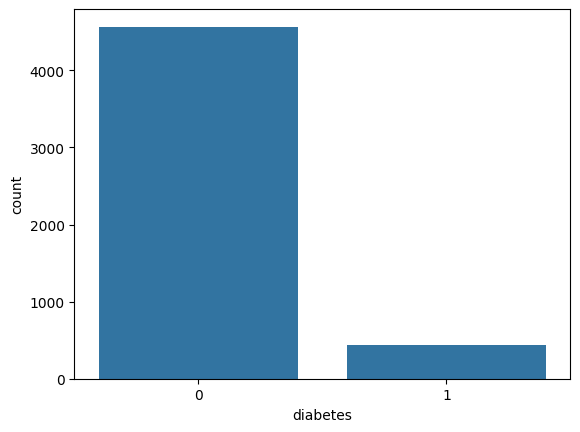

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['diabetes'],data=df)
plt.show()

#### The dataset is highly imbalanced.

We explore 2 methods of imbalance datasets which are **undersampling** and **oversampling**. But we would perform data preprocessing first.

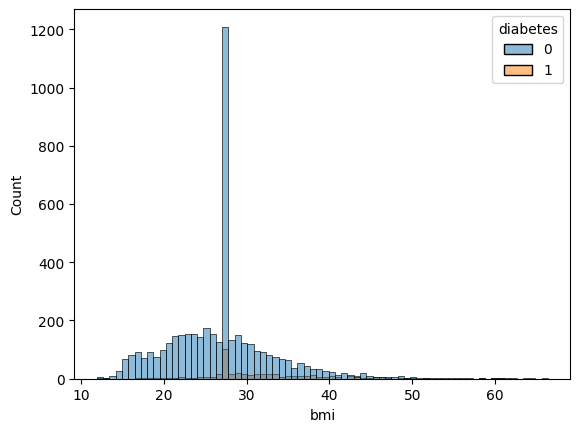

In [11]:
sns.histplot(data=df,x='bmi',hue='diabetes')
plt.show()

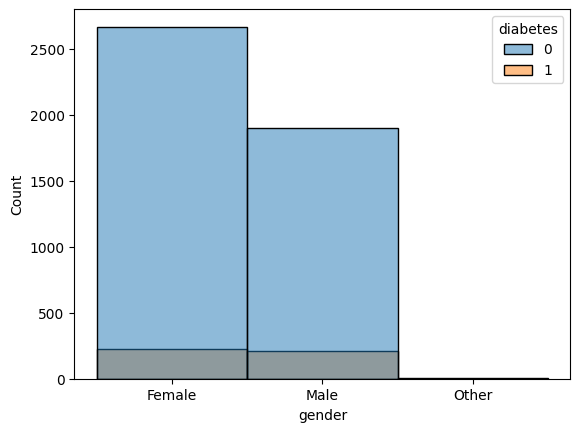

In [12]:
sns.histplot(data=df,x='gender',hue='diabetes')
plt.show()

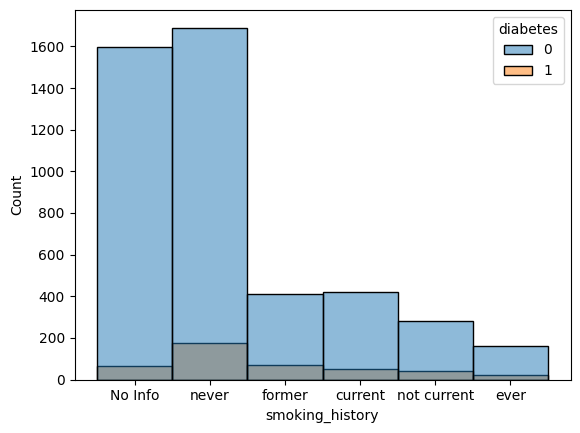

In [13]:
sns.histplot(data=df,x='smoking_history',hue='diabetes')
plt.show()

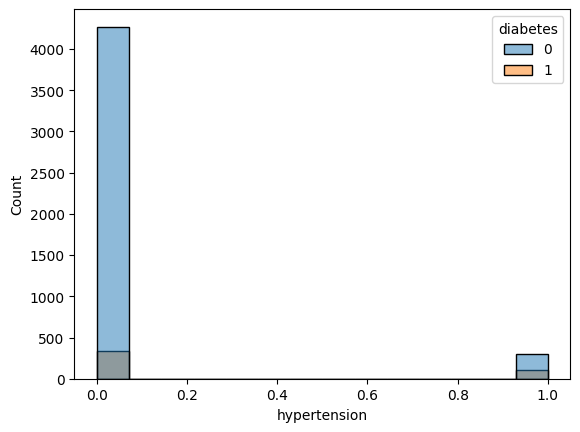

In [14]:
sns.histplot(data=df,x='hypertension',hue='diabetes')
plt.show()

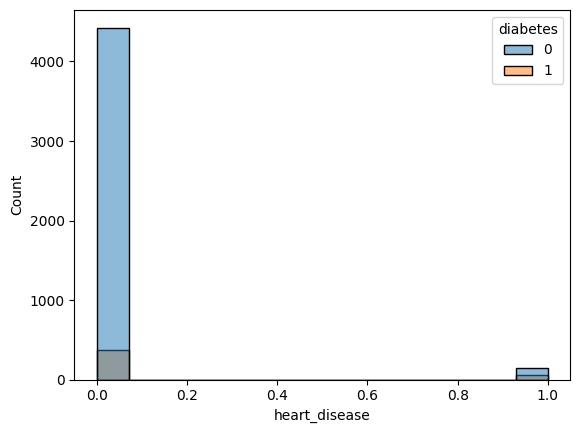

In [15]:
sns.histplot(data=df,x='heart_disease',hue='diabetes')
plt.show()

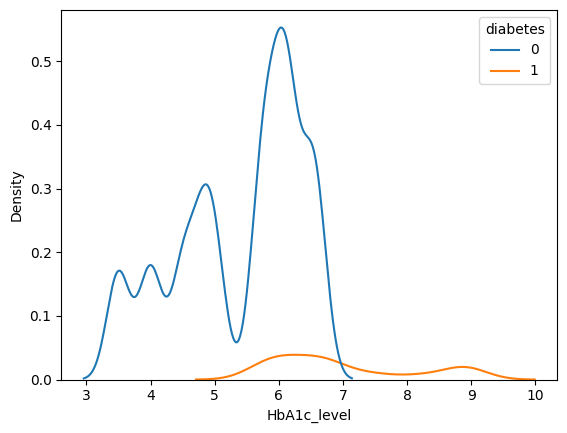

In [16]:
sns.kdeplot(data=df,x='HbA1c_level',hue='diabetes')
plt.show()

In [17]:
df['HbA1c_level'].value_counts()

HbA1c_level
6.2    431
6.0    421
5.8    418
6.5    417
6.6    411
6.1    410
4.0    390
5.7    388
5.0    383
4.8    379
3.5    377
4.5    372
8.8     44
6.8     40
9.0     39
7.5     30
8.2     25
7.0     25
Name: count, dtype: int64

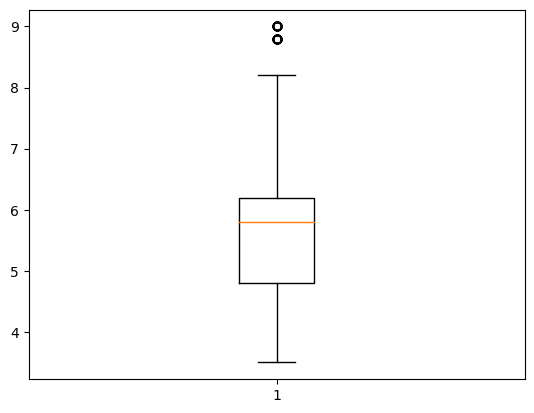

In [18]:
plt.boxplot(df['HbA1c_level'])
plt.show()

In [19]:
mean = df['HbA1c_level'].mean()
std  = df['HbA1c_level'].std()
 
# Calculate the lower and upper bounds
lower_bound = mean - std*2
upper_bound = mean + std*2
 
print('Lower Bound :',lower_bound)
print('Upper Bound :',upper_bound)
 
# Drop the outliers
df = df[(df['HbA1c_level'] >= lower_bound) 
                & (df['HbA1c_level'] <= upper_bound)]

Lower Bound : 3.3690141128472573
Upper Bound : 7.695465887152743


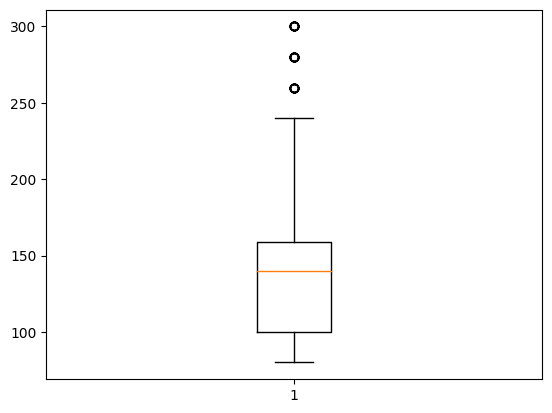

In [20]:
plt.boxplot(df['blood_glucose_level'])
plt.show()

In [21]:
mean = df['blood_glucose_level'].mean()
std  = df['blood_glucose_level'].std()
 
# Calculate the lower and upper bounds
lower_bound = mean - std*2
upper_bound = mean + std*2
 
print('Lower Bound :',lower_bound)
print('Upper Bound :',upper_bound)
 
# Drop the outliers
df = df[(df['blood_glucose_level'] >= lower_bound) 
                & (df['blood_glucose_level'] <= upper_bound)]

Lower Bound : 58.35093694263239
Upper Bound : 215.9687686992319


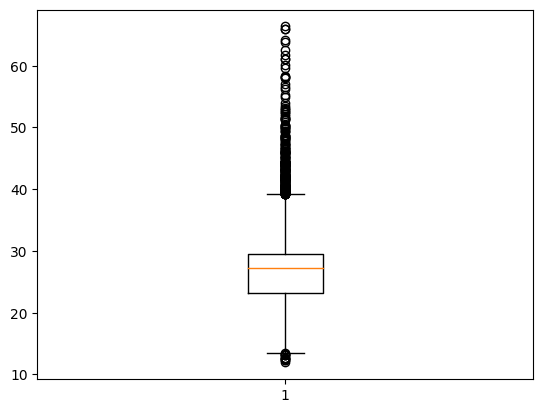

In [22]:
plt.boxplot(df['bmi'])
plt.show()

In [23]:
mean = df['bmi'].mean()
std  = df['bmi'].std()
 
# Calculate the lower and upper bounds
lower_bound = mean - std*2
upper_bound = mean + std*2
 
print('Lower Bound :',lower_bound)
print('Upper Bound :',upper_bound)
 
# Drop the outliers
df = df[(df['bmi'] >= lower_bound) 
                & (df['bmi'] <= upper_bound)]

Lower Bound : 13.869430865902046
Upper Bound : 40.45814578256498


In [24]:
df['diabetes'].value_counts()

diabetes
0    4398
1     160
Name: count, dtype: int64

#### Let's deal with categorical values


In [25]:
df['smoking_history'].value_counts()

smoking_history
never          1694
No Info        1578
current         424
former          421
not current     281
ever            160
Name: count, dtype: int64

The people with no info on smoking history are of no use for us in training so we will drop those rows which have **smoking_history** = **'No Info'**.

In [26]:
df = df[df['smoking_history']!='No Info']

In [27]:
df['smoking_history'].value_counts()

smoking_history
never          1694
current         424
former          421
not current     281
ever            160
Name: count, dtype: int64

In [28]:
df['age'].unique()

array([19.  , 22.  , 62.  , 18.  , 30.  , 16.  , 75.  , 51.  , 43.  ,
       66.  , 40.  , 28.  , 10.  , 67.  , 74.  , 53.  , 38.  , 77.  ,
       54.  , 80.  , 34.  , 26.  , 37.  , 68.  , 13.  , 55.  , 57.  ,
       59.  ,  3.  , 73.  , 61.  , 36.  , 76.  , 49.  , 29.  , 42.  ,
       72.  , 46.  , 69.  , 56.  ,  1.48, 21.  , 31.  , 60.  , 33.  ,
       24.  , 44.  , 45.  , 25.  , 79.  , 65.  , 58.  , 50.  , 52.  ,
       63.  , 48.  ,  6.  , 70.  , 71.  , 11.  , 23.  , 35.  , 32.  ,
        9.  , 17.  , 47.  , 64.  , 27.  ,  7.  , 15.  ,  0.48,  2.  ,
       41.  , 14.  , 78.  , 39.  ,  4.  , 20.  , 12.  ,  8.  ,  5.  ,
        0.56,  1.8 ,  1.4 ])

Generally, the **age** feature is not considered as factor in predicting diabetes but now-a-days even  new born babies are diagnosed with diabetes too because of genes. In the data some of the age values are in decimals which is not good for the training purpose plus we will also check for smoking_history of patient whose age is less than 5 years. If there is smoking history for patients with age less than 5 will not be considered and removed.
[The article for diabetes in new born babies.](https://doi.org/10.1016%2Fj.clp.2017.10.006)

In [29]:
df['age'] = df['age'].astype(int)

In [30]:
df['age'].unique()

array([19, 22, 62, 18, 30, 16, 75, 51, 43, 66, 40, 28, 10, 67, 74, 53, 38,
       77, 54, 80, 34, 26, 37, 68, 13, 55, 57, 59,  3, 73, 61, 36, 76, 49,
       29, 42, 72, 46, 69, 56,  1, 21, 31, 60, 33, 24, 44, 45, 25, 79, 65,
       58, 50, 52, 63, 48,  6, 70, 71, 11, 23, 35, 32,  9, 17, 47, 64, 27,
        7, 15,  0,  2, 41, 14, 78, 39,  4, 20, 12,  8,  5])

Removing the data points with age = 0.

In [31]:
df = df[df['age']!=0]

/home/u213918/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


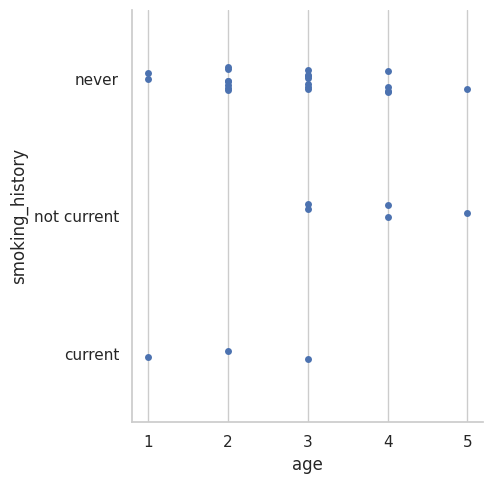

In [32]:
sns.set(style="whitegrid")
sns.catplot(x="age", y="smoking_history", data=df.loc[df['age'] <=5])
plt.show()

We can see some datapoints are showing patients with age less than equal to 5 having smoking history to current or ever which doesn't make sense at all and need to be removed. 

In [33]:
df = df[~((df['age'] < 5) & df['smoking_history'].isin(['ever', 'current']))]

/home/u213918/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


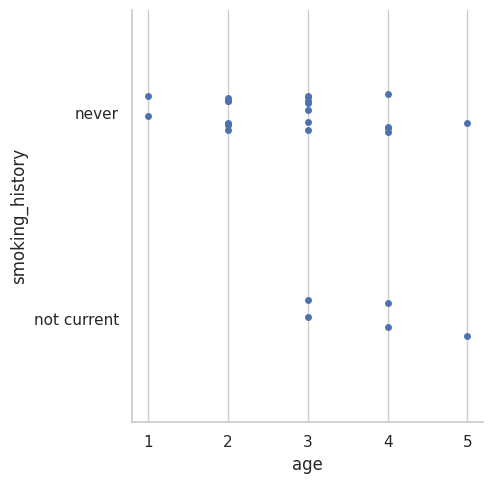

In [34]:
sns.set(style="whitegrid")
sns.catplot(x="age", y="smoking_history", data=df.loc[df['age'] <=5])
plt.show()

The gender feature is also not considered in the role of predicting the diabetes which is explained in a detailed manner in the below link. In short both the gender have different levels of harmones secretion like insulin which makes women more sensitive to having diabetes as compared to men.
[The paper on how gender plays a vital role in predicting diabetes.](https://doi.org/10.3390%2Fijms23168850)

In [35]:
df['gender'].value_counts()

gender
Female    1784
Male      1190
Other        1
Name: count, dtype: int64

#### We will drop 'Other' of gender.

In [36]:
df = df[df['gender'] != 'Other']

In [37]:
df['gender'].value_counts()

gender
Female    1784
Male      1190
Name: count, dtype: int64

In [38]:
df = pd.get_dummies(data=df, drop_first=True)
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
34774,19,0,0,22.74,6.6,85,0,True,False,False,True,False
80788,22,0,0,28.78,4.5,200,0,False,False,False,True,False
69385,62,0,0,27.32,3.5,158,0,True,False,True,False,False
35032,18,0,0,20.97,4.0,160,0,False,False,False,True,False
28678,30,0,0,27.32,6.5,145,0,False,False,False,True,False


In [39]:
change_col =  ['gender_Male','smoking_history_ever','smoking_history_former','smoking_history_never','smoking_history_not current']
for col in change_col:
    df[col] = df[col].replace(False, 0)
    df[col] = df[col].replace(True, 1)
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
34774,19,0,0,22.74,6.6,85,0,1,0,0,1,0
80788,22,0,0,28.78,4.5,200,0,0,0,0,1,0
69385,62,0,0,27.32,3.5,158,0,1,0,1,0,0
35032,18,0,0,20.97,4.0,160,0,0,0,0,1,0
28678,30,0,0,27.32,6.5,145,0,0,0,0,1,0


In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
columns_to_scale = ['age', 'bmi','HbA1c_level','blood_glucose_level']
scaler.fit(df[columns_to_scale])
scaled_columns = scaler.transform(df[columns_to_scale])
df[columns_to_scale] = scaled_columns

In [41]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
34774,0.227848,0,0,0.332577,0.775,0.041667,0,1,0,0,1,0
80788,0.265823,0,0,0.560847,0.250,1.000000,0,0,0,0,1,0
69385,0.772152,0,0,0.505669,0.000,0.650000,0,1,0,1,0,0
35032,0.215190,0,0,0.265684,0.125,0.666667,0,0,0,0,1,0
28678,0.367089,0,0,0.505669,0.750,0.541667,0,0,0,0,1,0


Now the data is preprocessed, now it's time to test the model with 2 types of dataset:
1. Undersampling
2. Oversampling

In [42]:
x = df.drop(['diabetes'], axis = 1)
y = df['diabetes']

# Undersampling

In [43]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
x_undersample, y_undersample = undersampler.fit_resample(x, y)

df_ux = pd.DataFrame(x_undersample, columns=x.columns)
df_uy = pd.Series(y_undersample)

In [44]:
from sklearn.model_selection import train_test_split

x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(df_ux, df_uy, test_size=0.2, random_state=42)
x_train_u.shape

(219, 11)

# Oversampling

In [45]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_oversample, y_oversample = smote.fit_resample(x, y)

df_ox = pd.DataFrame(x_oversample, columns=x.columns)
df_oy = pd.Series(y_oversample)

In [46]:
from sklearn.model_selection import train_test_split

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(df_ox, df_oy, test_size=0.2, random_state=42)
x_train_o.shape

(4539, 11)

# Models

In [47]:
# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [48]:
key = ['Logistic Regression','K-Neighbors Classifier','Decision Tree Classifier','Random Forest Classifier','Adaboost Classifier','Gradient Boosting Classifier','XGB Classifier','SVM']
value = [LogisticRegression(), KNeighborsClassifier(n_neighbors = 2, weights ='uniform'), DecisionTreeClassifier(random_state=10), RandomForestClassifier(n_estimators=60, random_state=0), GradientBoostingClassifier(random_state=20), AdaBoostClassifier(), xgb.XGBClassifier(random_state=0,booster="gbtree"),SVC(kernel="linear")]
models = dict(zip(key,value))
models

{'Logistic Regression': LogisticRegression(),
 'K-Neighbors Classifier': KNeighborsClassifier(n_neighbors=2),
 'Decision Tree Classifier': DecisionTreeClassifier(random_state=10),
 'Random Forest Classifier': RandomForestClassifier(n_estimators=60, random_state=0),
 'Adaboost Classifier': GradientBoostingClassifier(random_state=20),
 'Gradient Boosting Classifier': AdaBoostClassifier(),
 'XGB Classifier': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_wei

### Model training for undersampling

In [49]:
predicted =[]
mod=[]
for name,algo in models.items():
    model=algo
    mod.append(name)
    model.fit(x_train_u,y_train_u)
    predict = model.predict(x_test_u)
    acc = accuracy_score(y_test_u, predict)
    predicted.append(acc*100)
    predict_train = model.predict(x_train_u)
    #print(name,(acc*100),"%")
    print(name,": Test Accuracy = ",(acc*100),"%")
    print(name,": Train Accuracy = ",(accuracy_score(y_train_u, predict_train)*100),"%")
    print(classification_report(y_test_u, predict))

Logistic Regression : Test Accuracy =  87.27272727272727 %
Logistic Regression : Train Accuracy =  84.93150684931507 %
              precision    recall  f1-score   support

           0       0.96      0.79      0.86        28
           1       0.81      0.96      0.88        27

    accuracy                           0.87        55
   macro avg       0.88      0.87      0.87        55
weighted avg       0.89      0.87      0.87        55

K-Neighbors Classifier : Test Accuracy =  70.9090909090909 %
K-Neighbors Classifier : Train Accuracy =  88.58447488584474 %
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        28
           1       0.74      0.63      0.68        27

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55

Decision Tree Classifier : Test Accuracy =  83.63636363636363 %
Decision Tree Classifier : Train Accura

In [50]:
data = pd.DataFrame({'Model': mod, 'Accuracy': predicted})
data

,Model,Accuracy
0,Logistic Regression,87.272727
1,K-Neighbors Classifier,70.909091
2,Decision Tree Classifier,83.636364
3,Random Forest Classifier,87.272727
4,Adaboost Classifier,85.454545
5,Gradient Boosting Classifier,85.454545
6,XGB Classifier,87.272727
7,SVM,89.090909


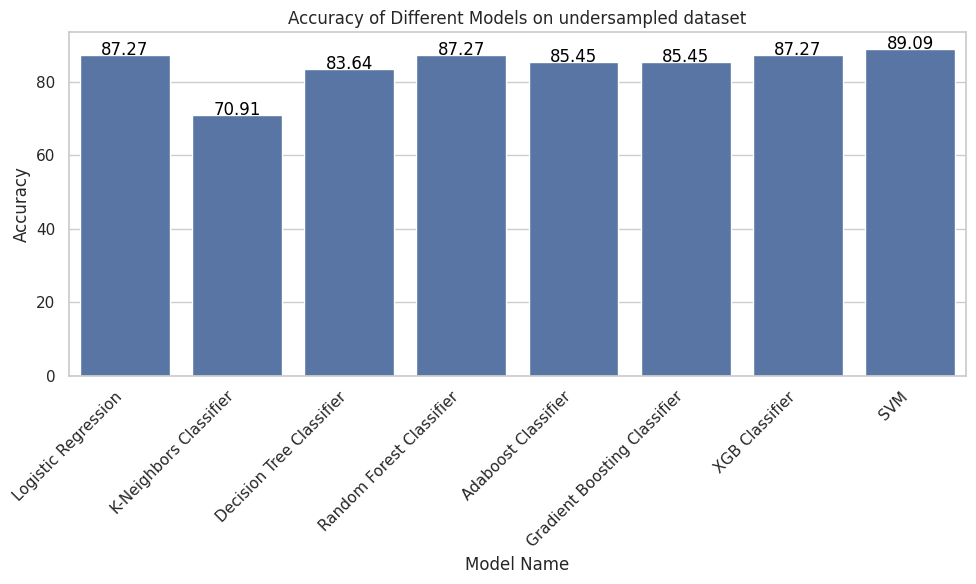

In [51]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=data)

for index, row in data.iterrows():
    plt.text(index, row['Accuracy'], round(row['Accuracy'], 2), color='black', ha="center")

plt.xticks(rotation=45, ha='right')

plt.title('Accuracy of Different Models on undersampled dataset')
plt.xlabel('Model Name')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### Model training for oversampling

In [52]:
predicted =[]
mod=[]
for name,algo in models.items():
    model=algo
    mod.append(name)
    model.fit(x_train_o,y_train_o)
    predict = model.predict(x_test_o)
    acc = accuracy_score(y_test_o, predict)
    predicted.append(acc*100)
    predict_train = model.predict(x_train_o)
    #print(name,(acc*100),"%")
    print(name,": Test Accuracy = ",(acc*100),"%")
    print(name,": Train Accuracy = ",(accuracy_score(y_train_o, predict_train)*100),"%")
    print(classification_report(y_test_o, predict))

Logistic Regression : Test Accuracy =  84.58149779735683 %
Logistic Regression : Train Accuracy =  86.38466622604098 %
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       580
           1       0.81      0.90      0.85       555

    accuracy                           0.85      1135
   macro avg       0.85      0.85      0.85      1135
weighted avg       0.85      0.85      0.85      1135

K-Neighbors Classifier : Test Accuracy =  94.8898678414097 %
K-Neighbors Classifier : Train Accuracy =  99.20687376074025 %
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       580
           1       0.92      0.98      0.95       555

    accuracy                           0.95      1135
   macro avg       0.95      0.95      0.95      1135
weighted avg       0.95      0.95      0.95      1135

Decision Tree Classifier : Test Accuracy =  94.27312775330397 %
Decision Tree Classifier : Train Accura

In [53]:
data1 = pd.DataFrame({'Model': mod, 'Accuracy': predicted})
data1

,Model,Accuracy
0,Logistic Regression,84.581498
1,K-Neighbors Classifier,94.889868
2,Decision Tree Classifier,94.273128
3,Random Forest Classifier,95.594714
4,Adaboost Classifier,95.330396
5,Gradient Boosting Classifier,92.422907
6,XGB Classifier,98.149780
7,SVM,84.493392


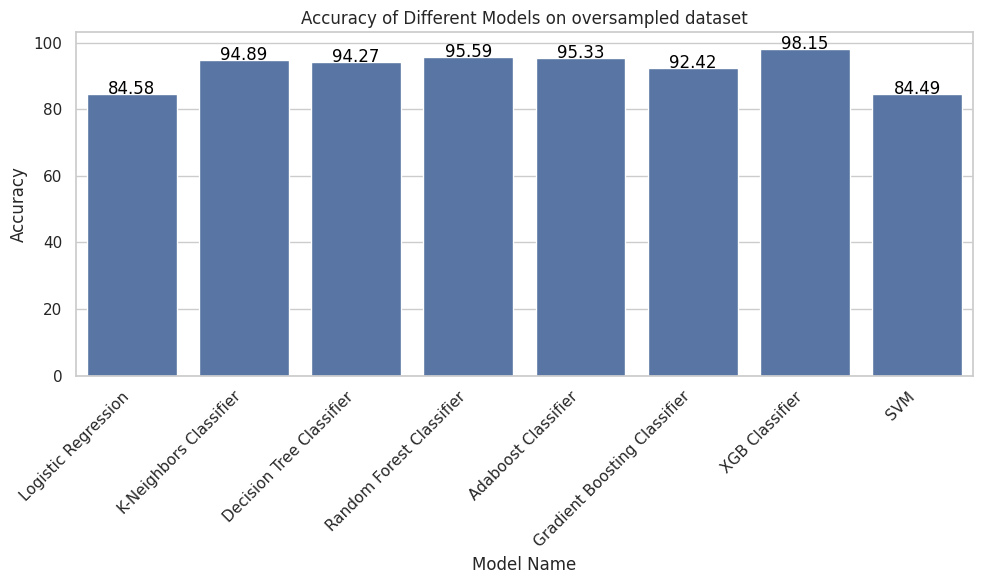

In [54]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=data1)

for index, row in data1.iterrows():
    plt.text(index, row['Accuracy'], round(row['Accuracy'], 2), color='black', ha="center")

plt.xticks(rotation=45, ha='right')

plt.title('Accuracy of Different Models on oversampled dataset')
plt.xlabel('Model Name')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Plotting ROC curve for undersampled dataset

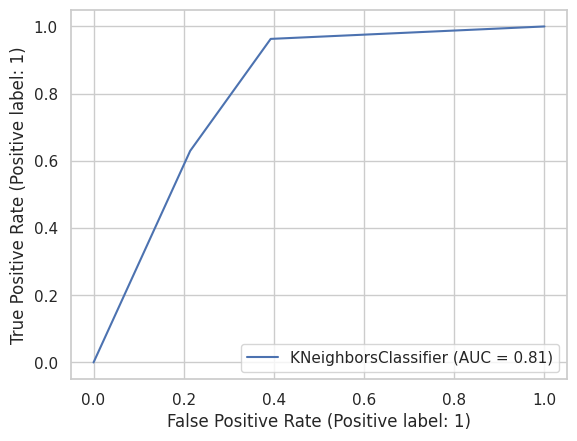

In [55]:
#kNN model has the lowest accuracy
from sklearn.metrics import RocCurveDisplay
kNN = KNeighborsClassifier(n_neighbors = 2, weights ='uniform')
kNN.fit(x_train_u,y_train_u)
ROC_kNN = RocCurveDisplay.from_estimator(kNN, x_test_u, y_test_u)

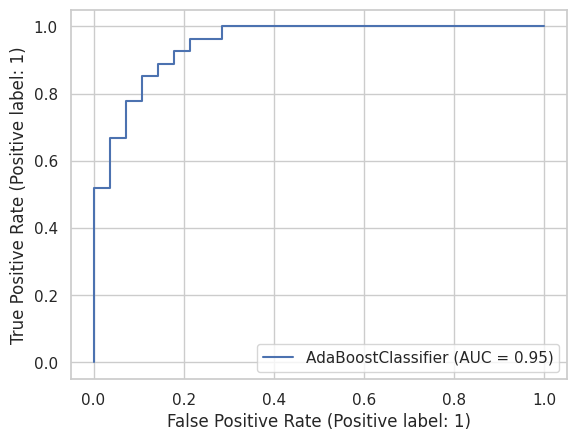

In [56]:
#AdaBoost has the highest accuracy
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(x_train_u,y_train_u)
ROC_AdaBoost= RocCurveDisplay.from_estimator(AdaBoost, x_test_u, y_test_u)

# Plotting ROC curve for oversampled dataset

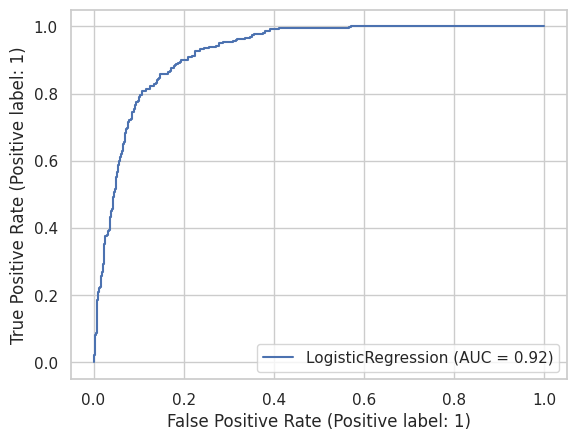

In [57]:
#Logistic regression model has the lowest accuracy
LR = LogisticRegression()
LR.fit(x_train_o,y_train_o)
ROC_LR = RocCurveDisplay.from_estimator(LR, x_test_o, y_test_o)

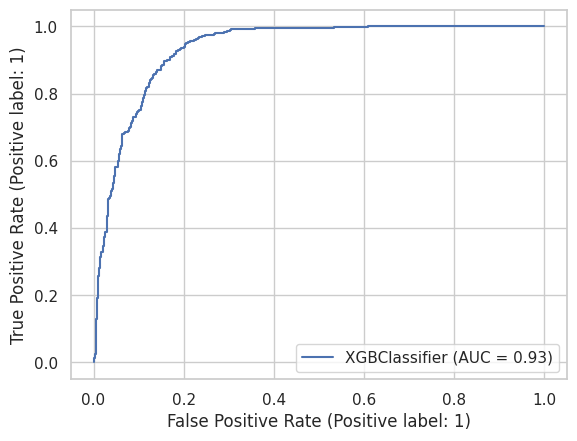

In [58]:
#XGBoost classifier model has the highest accuracy
XGB = xgb.XGBClassifier(random_state=0,booster="gbtree")
XGB.fit(x_train_u,y_train_u)
ROC_XGB = RocCurveDisplay.from_estimator(XGB, x_test_o, y_test_o)

In [59]:
y = df['diabetes']
X = df.drop(columns = ['diabetes'])

In [60]:
# Initial class distribution
print("Class distribution before SMOTE:")
print(y.value_counts())

# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

# Class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y).value_counts())

Class distribution before SMOTE:
diabetes
0    2837
1     137
Name: count, dtype: int64

Class distribution after SMOTE:
diabetes
0    2837
1    2837
Name: count, dtype: int64


In [61]:
from sklearn.model_selection import GridSearchCV, cross_val_score
param_grid = {'n_estimators': [100, 200, 250, 300, 350, 400, 500]}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Grid Search Results:
Best Parameters: {'n_estimators': 200}
Best Cross-Validated Accuracy: 0.9672203187034318


In [62]:
param_grid = {'n_estimators': [100, 200, 250, 300, 350, 400, 500]}
model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Grid Search Results:
Best Parameters: {'n_estimators': 400}
Best Cross-Validated Accuracy: 0.9682796074866559


In [63]:
param_grid = {'n_estimators': [100, 200, 250, 300, 350, 400, 500]}
model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
print("Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Grid Search Results:
Best Parameters: {'n_estimators': 400}
Best Cross-Validated Accuracy: 0.9739191509529249


In [64]:
param_grid = {'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11]}

# Create a KNeighborsClassifier
knn_classifier = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the results
print("Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Grid Search Results:
Best Parameters: {'n_neighbors': 4}
Best Cross-Validated Accuracy: 0.9386683137931302


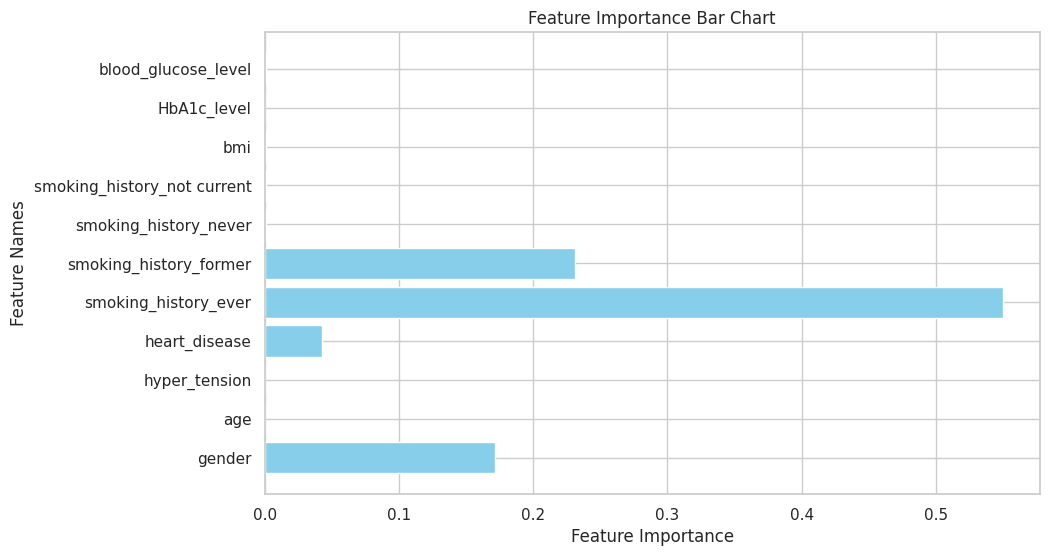

In [65]:
model = GradientBoostingClassifier(n_estimators=300, random_state=42)
model.fit(X, y)
feature_importances = model.feature_importances_
feature_names = ['gender', 'age', 'hyper_tension', 'heart_disease', 'smoking_history_ever','smoking_history_former','smoking_history_never','smoking_history_not current', 'bmi', 'HbA1c_level', 'blood_glucose_level']
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Bar Chart')
plt.show()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
model = GradientBoostingClassifier(n_estimators=300, random_state=42, )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 97.70925110132158
Precision: 0.9817850637522769
Recall: 0.9711711711711711
F1 Score: 0.9764492753623187


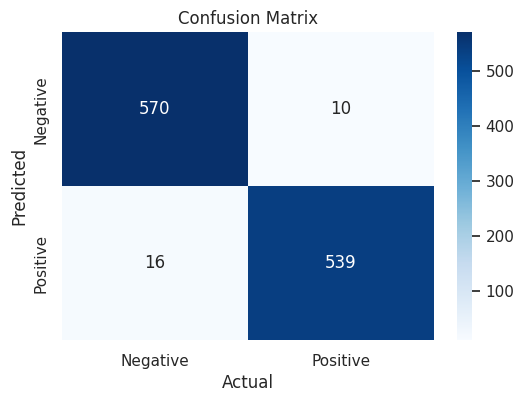

In [68]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [69]:
from sklearn.ensemble import VotingClassifier

# Initialize individual models
random_forest = RandomForestClassifier(random_state=42, n_estimators=250)
gradient_boosting = GradientBoostingClassifier(random_state=42, n_estimators=300)

# Create a Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('gb', gradient_boosting)
], voting='soft')  # Use 'hard' for majority voting, 'soft' for weighted voting

# Evaluate the Voting Classifier
cv_scores = cross_val_score(voting_classifier, X, y, cv=5, scoring='accuracy')
print(f'Voting Classifier: Mean Accuracy - {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')


Voting Classifier: Mean Accuracy - 0.9757 (+/- 0.0193)


Accuracy: 97.44493392070484
Precision: 0.9663120567375887
Recall: 0.9819819819819819
F1 Score: 0.9740840035746202


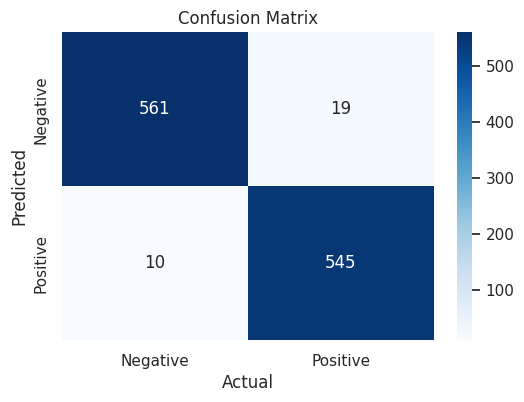

In [70]:
model = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('gb', gradient_boosting)
], voting='soft')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [71]:
from sklearn.ensemble import StackingClassifier

# Initialize individual models
random_forest = RandomForestClassifier(random_state=42, n_estimators=250)
gradient_boosting = GradientBoostingClassifier(random_state=42, n_estimators=300)

# Create a Stacking Classifier
stacking_classifier = StackingClassifier(estimators=[
    ('rf', random_forest),
    ('gb', gradient_boosting)
], final_estimator=GradientBoostingClassifier(random_state=42))

# Evaluate the Stacking Classifier
cv_scores = cross_val_score(stacking_classifier, X, y, cv=5, scoring='accuracy')
print(f'Stacking Classifier: Mean Accuracy - {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})')


Stacking Classifier: Mean Accuracy - 0.9781 (+/- 0.0201)
